# 1. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc
)
from imblearn.over_sampling import SMOTE

# 2. Downloading & Loading the Dataset

In [2]:
# Downloading dataset from KaggleHub
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset files:", path)

# Loading the dataset
file_path = f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

100%|██████████| 172k/172k [00:00<00:00, 31.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


# 3. EDA


=== Dataset Summary ===
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMo

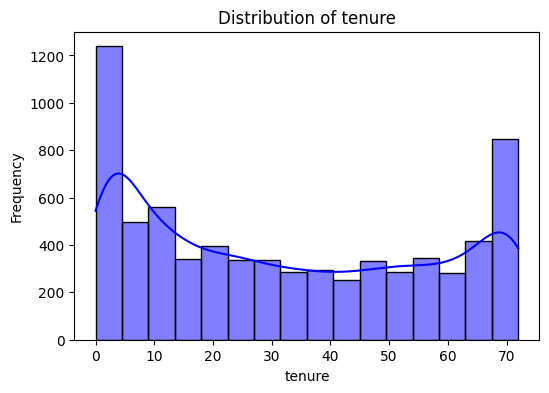

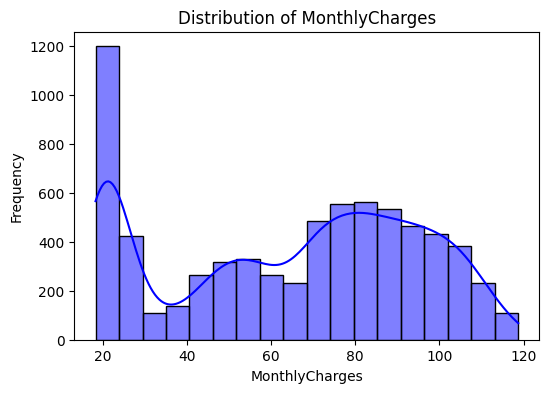

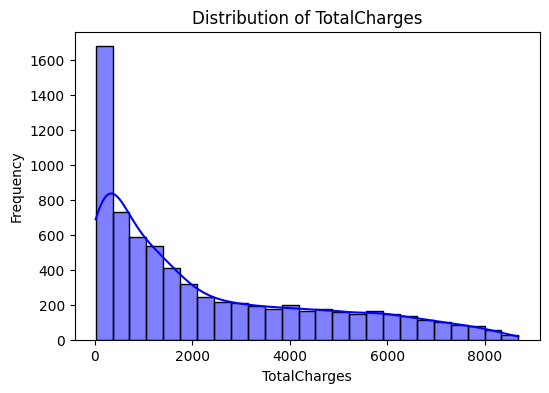

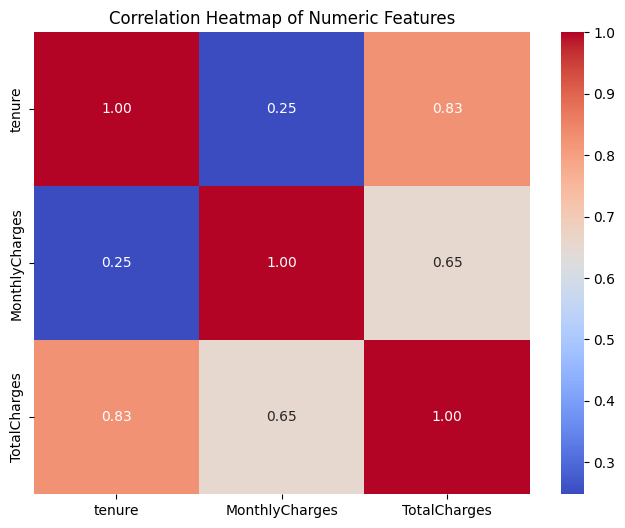

<ipython-input-3-d6d4e130d54a>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_eda, x=feature, palette='viridis')


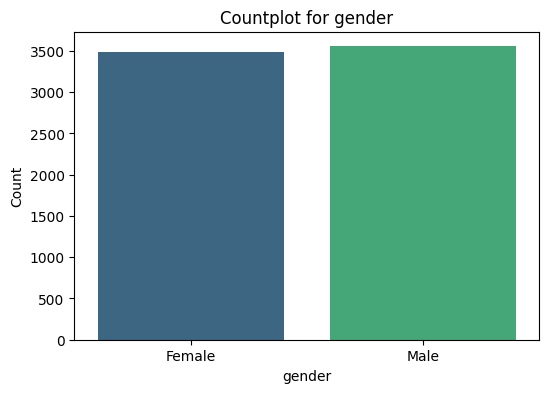

<ipython-input-3-d6d4e130d54a>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_eda, x=feature, palette='viridis')


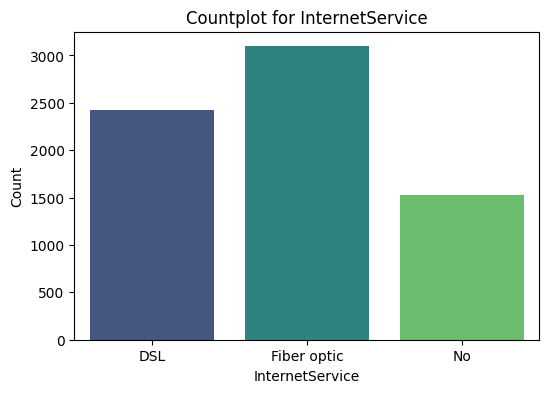

<ipython-input-3-d6d4e130d54a>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_eda, x=feature, palette='viridis')


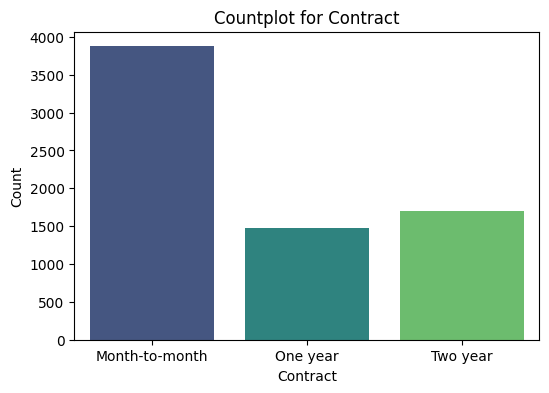

In [3]:
# Dataset Summary, Information and Description
print("\n=== Dataset Summary ===")
print(df.head())

print("\n=== Dataset Information ===")
print(df.info())

print("\n=== Dataset Description ===")
print(df.describe())

print("\nPotential Challenges:")
print(" - Class Imbalance: The target variable 'Churn' is imbalanced. (Plan: Addressed via SMOTE)")
print(" - Data Quality: The 'TotalCharges' column may contain non-numeric values that need conversion.")
print(" - Missing Values: Numerical features with missing values are imputed using the median.")

df_eda = df.copy()
df_eda['TotalCharges'] = pd.to_numeric(df_eda['TotalCharges'], errors='coerce')

# Creating Histograms
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
for feature in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_eda[feature].dropna(), kde=True, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_eda[numeric_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# Countplots for categorical features
categorical_features = ['gender', 'InternetService', 'Contract']
for feature in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df_eda, x=feature, palette='viridis')
    plt.title(f'Countplot for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()


# 4. Data Preprocessing & SMOTE

<ipython-input-4-68c624c1fb15>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='coolwarm')


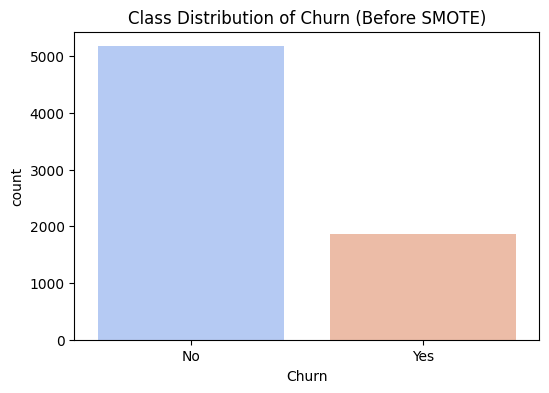

<ipython-input-4-68c624c1fb15>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='coolwarm')


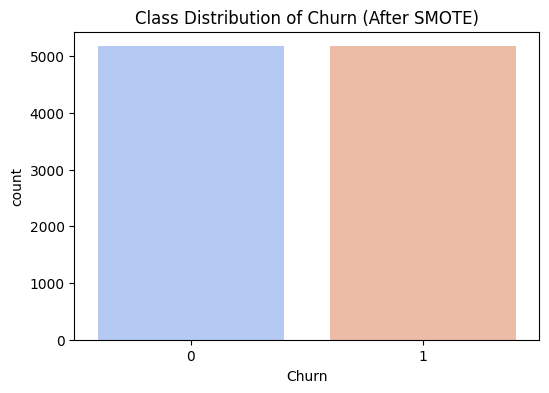

In [4]:
# Dropping customerID
df.drop('customerID', axis=1, inplace=True)

# Converting 'TotalCharges' to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handling missing values with median imputation
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Visualizing class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='coolwarm')
plt.title("Class Distribution of Churn (Before SMOTE)")
plt.show()

# Encoding categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

# Splitting dataset into X and y
X = df.drop(columns=['Churn'])
y = df['Churn']

# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualizing class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled, palette='coolwarm')
plt.title("Class Distribution of Churn (After SMOTE)")
plt.show()

# Scaling numerical features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Model Definition

In [5]:
# Defining models
models = {
    'Logistic Regression': LogisticRegression(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
}

# 6. Model Training & Threshold Optimization


### Logistic Regression Model ###

Optimized Threshold: 0.45

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      1021
           1       0.78      0.89      0.83      1049

    accuracy                           0.82      2070
   macro avg       0.82      0.81      0.81      2070
weighted avg       0.82      0.82      0.81      2070


Confusion Matrix:
[[759 262]
 [119 930]]


<Figure size 600x600 with 0 Axes>

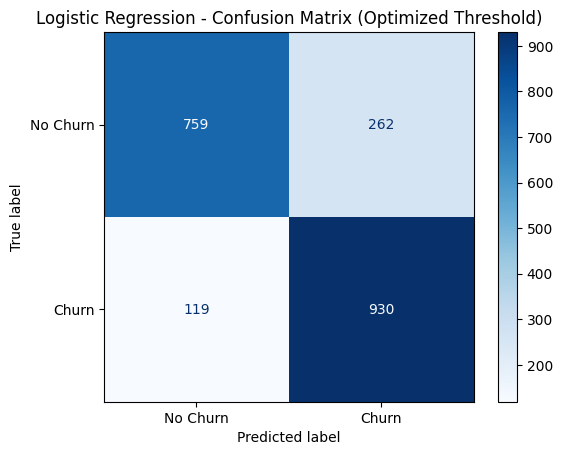

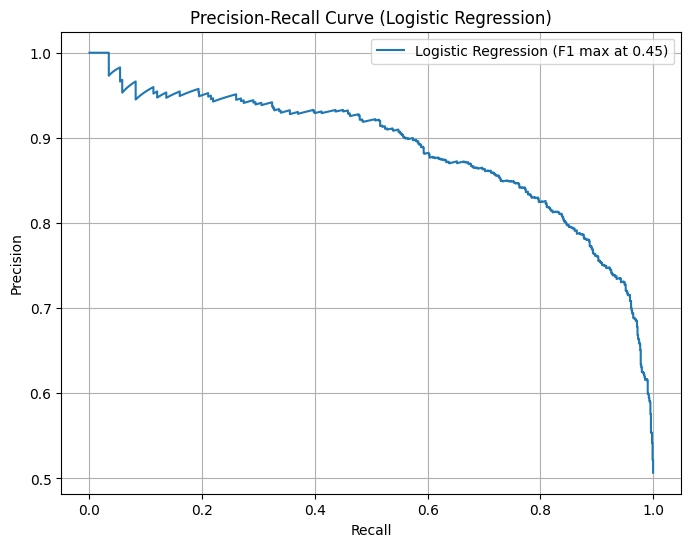

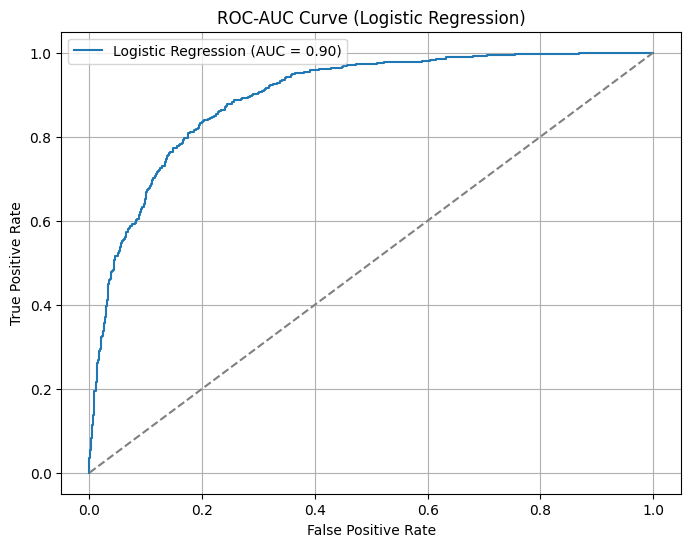


### XGBoost Model ###


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:30:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Optimized Threshold: 0.43

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1021
           1       0.83      0.88      0.85      1049

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070


Confusion Matrix:
[[836 185]
 [129 920]]


<Figure size 600x600 with 0 Axes>

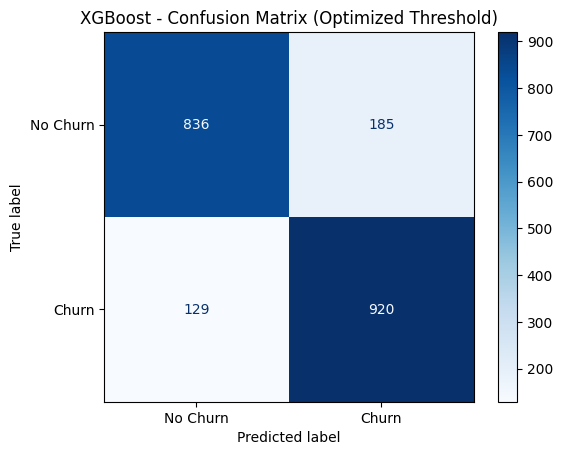

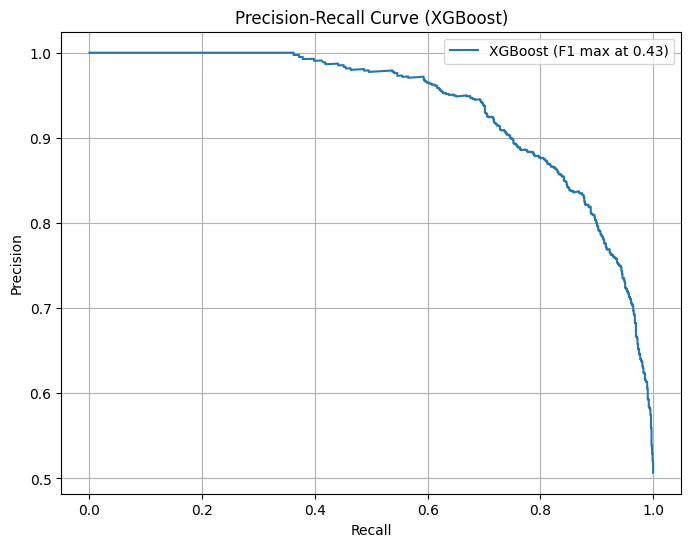

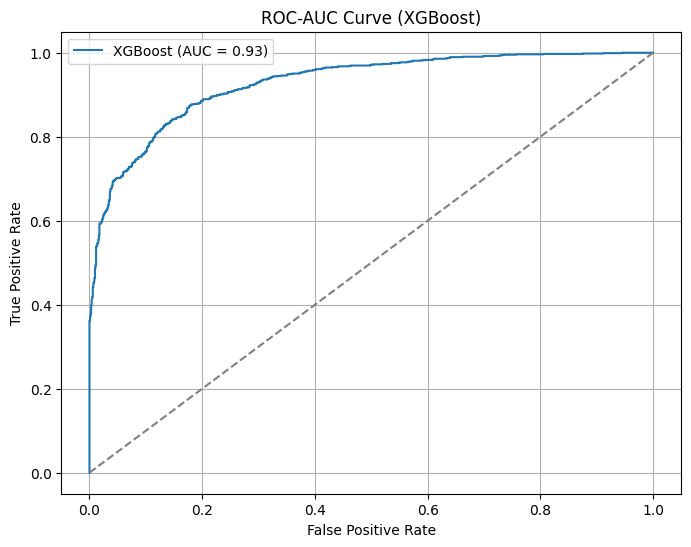


### Random Forest Model ###

Optimized Threshold: 0.40

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1021
           1       0.79      0.93      0.86      1049

    accuracy                           0.84      2070
   macro avg       0.85      0.84      0.84      2070
weighted avg       0.85      0.84      0.84      2070


Confusion Matrix:
[[766 255]
 [ 75 974]]


<Figure size 600x600 with 0 Axes>

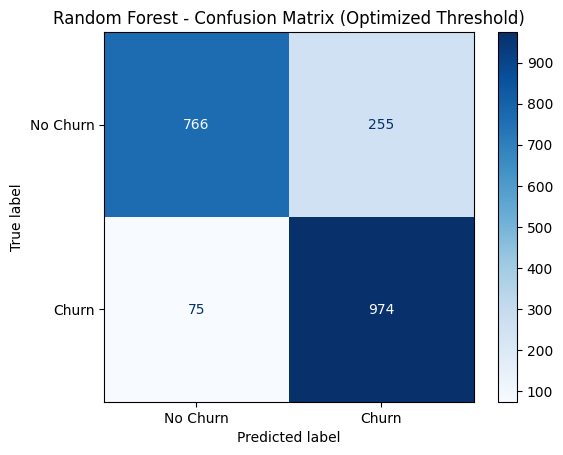

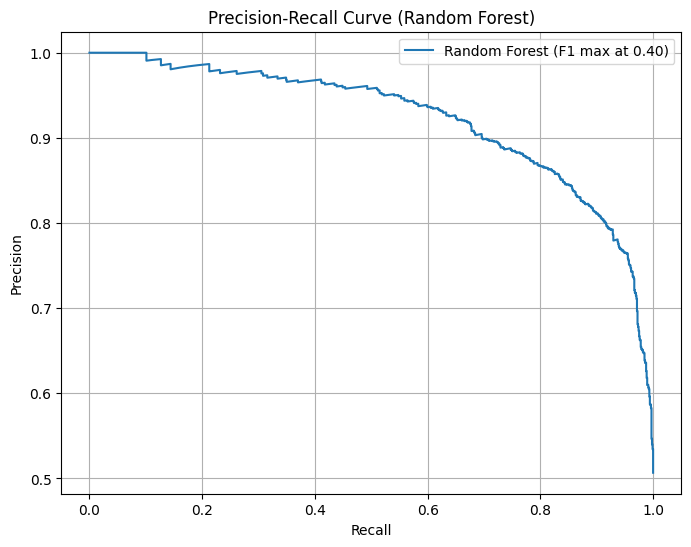

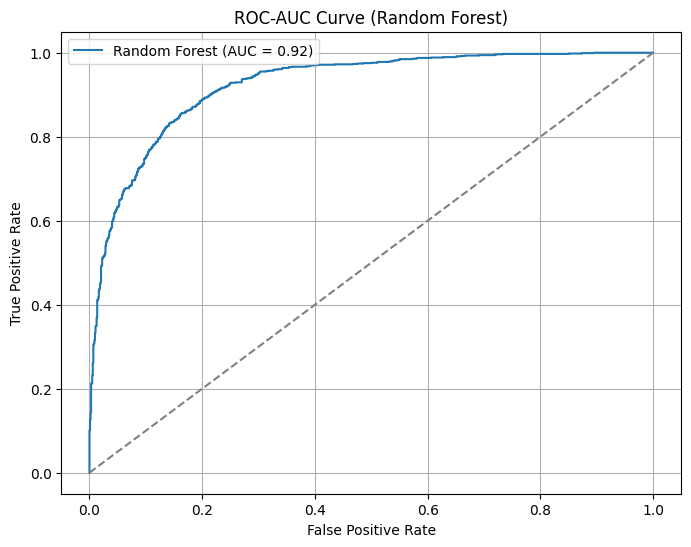

In [6]:
for name, model in models.items():
    print(f"\n### {name} Model ###")
    # Training the model
    model.fit(X_train, y_train)

    # Predicting probabilities
    y_prob = model.predict_proba(X_test)[:, 1]

    # Finding optimal threshold using Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Applying the optimized threshold
    y_pred = (y_prob >= best_threshold).astype(int)

    # Classification report and confusion matrix
    print(f"\nOptimized Threshold: {best_threshold:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)

    # Plotting Confusion Matrix
    plt.figure(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Churn', 'Churn'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{name} - Confusion Matrix (Optimized Threshold)")
    plt.show()

    # Plotting Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'{name} (F1 max at {best_threshold:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({name})')
    plt.legend()
    plt.grid()
    plt.show()

    # Plotting ROC-AUC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle="--", color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-AUC Curve ({name})')
    plt.legend()
    plt.grid()
    plt.show()

# 7. Feature Importance (Random Forest)

<ipython-input-7-fcdf544b9b4a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=feature_names[sorted_idx], palette='viridis')


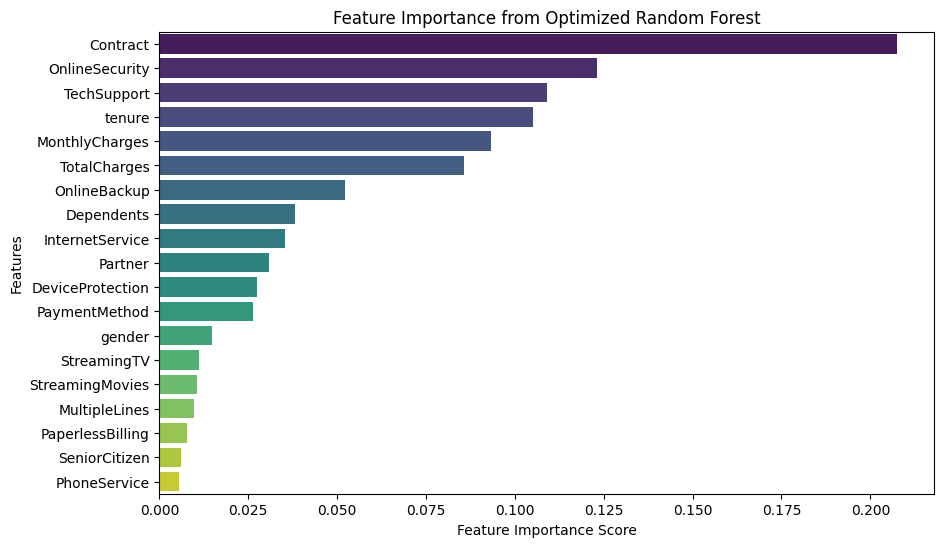

In [7]:
# Plotting feature importance from Random Forest Model
rf_model = models['Random Forest']
feature_importances = rf_model.feature_importances_
feature_names = df.drop(columns=['Churn']).columns
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_idx], y=feature_names[sorted_idx], palette='viridis')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Optimized Random Forest")
plt.show()

# 8. SHAP Analysis


=== SHAP Analysis for XGBoost ===


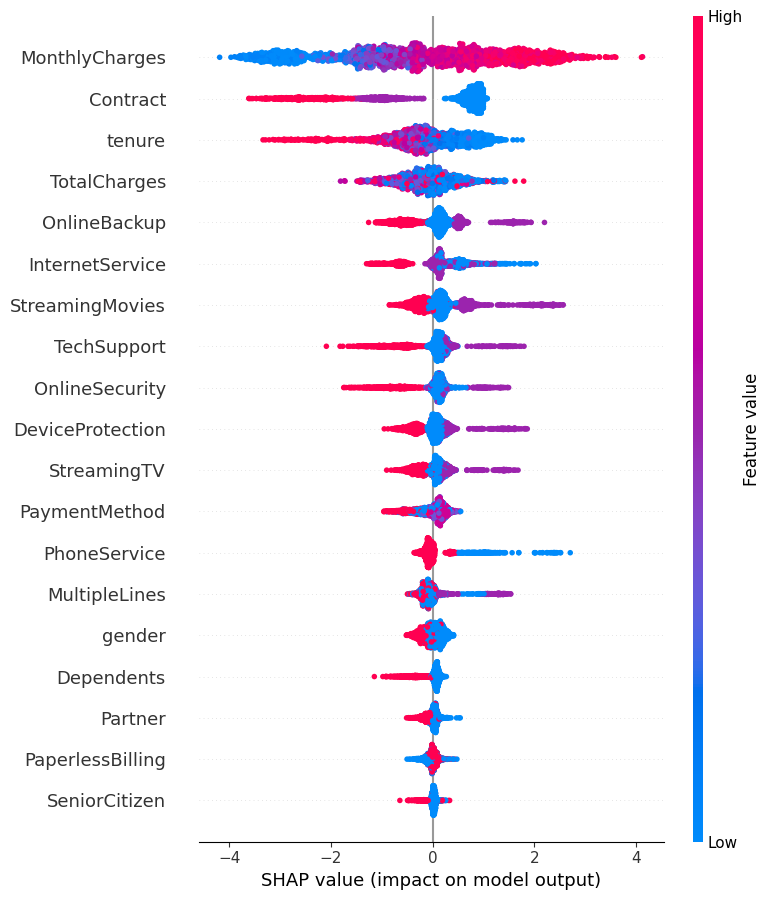

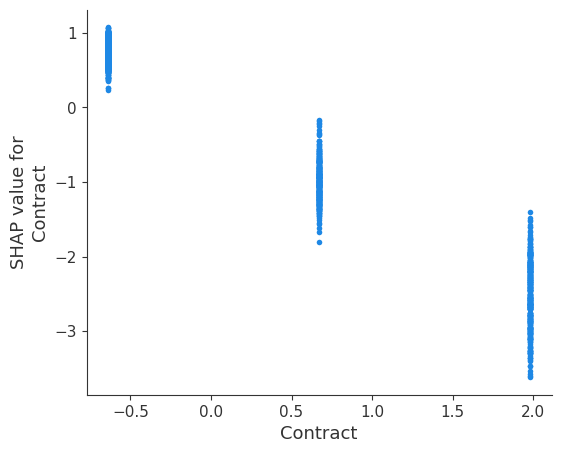

In [8]:
# Converting X_test back to a DataFrame for SHAP analysis
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Determining the top feature from Random Forest for the dependence plot for XGBoost
top_feature = feature_names[sorted_idx[0]]

# SHAP Analysis for XGBoost
print("\n=== SHAP Analysis for XGBoost ===")
xgb_model = models['XGBoost']
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test_df)
shap.summary_plot(xgb_shap_values, X_test_df, feature_names=feature_names, show=True)

if isinstance(xgb_shap_values, list):
    xgb_shap_dep = xgb_shap_values[1]
else:
    xgb_shap_dep = xgb_shap_values
shap.dependence_plot(top_feature, xgb_shap_dep, X_test_df, feature_names=feature_names, interaction_index=None, show=True)

Mean Absolute SHAP Values (Positive Class Only):
gender: 0.0172
SeniorCitizen: 0.0039
Partner: 0.0241
Dependents: 0.0292
tenure: 0.0523
PhoneService: 0.0044
MultipleLines: 0.0027
InternetService: 0.0292
OnlineSecurity: 0.0640
OnlineBackup: 0.0330
DeviceProtection: 0.0178
TechSupport: 0.0555
StreamingTV: 0.0045
StreamingMovies: 0.0032
Contract: 0.1131
PaperlessBilling: 0.0019
PaymentMethod: 0.0161
MonthlyCharges: 0.0513
TotalCharges: 0.0232


<ipython-input-13-483a5bee8057>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_abs_shap, y=feature_names, palette='viridis')


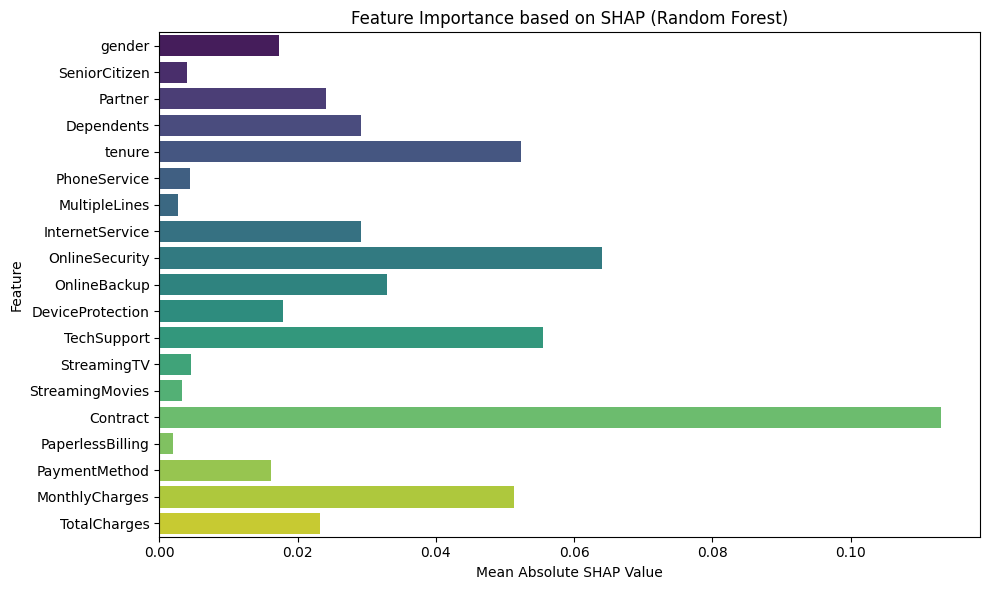

In [13]:
# Random Forest SHAP Analysis
rf_model = models['Random Forest']

# Calculating SHAP values
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test_df)

# Extracting only the positive class
shap_pos_class = rf_shap_values[:, :, 1]

# Averaging across samples
mean_abs_shap = np.mean(np.abs(shap_pos_class), axis=0)

print("Mean Absolute SHAP Values (Positive Class Only):")
for feature, shap_val in zip(feature_names, mean_abs_shap):
    print(f"{feature}: {shap_val:.4f}")

# Plotting feature importance based on SHAP
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_abs_shap, y=feature_names, palette='viridis')
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.title("Feature Importance based on SHAP (Random Forest)")
plt.tight_layout()
plt.show()


---